# Software profesional en Acústica 2024-25 (M2i)

*This notebook contains a modification of the notebook [FEM_Helmholtz_equation_Robin](https://github.com/spatialaudio/computational_acoustics/blob/master/FEM_Helmholtz_equation_Robin.ipynb), created by Sascha Spors, Frank Schultz, Computational Acoustics Examples, 2018. The text/images are licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/). The code is released under the [MIT license](https://opensource.org/licenses/MIT).*

First, we need to install on the fly FEniCS 2019.1.0 using the [FEM on Colab](https://fem-on-colab.github.io/packages.html) install script:

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# Numerical Solution of the Helmholtz Equation in unbounded domains with Perfectly Matched Layers and a Finite Element Method

This notebook illustrates the numerical solution of the wave equation for an harmonic excitation stated in an unbounded domain using a Finite Element Method. To truncate the unbounded domain, the Perfectly Matched Layer (PML) technique is used. 

## Problem Statement

The homogeneous Helmholtz equation is given as

\begin{equation}
c^2\Delta P(\boldsymbol{x}) + \omega^2 P(\boldsymbol{x}) = 0\qquad \text{for }\quad\boldsymbol{x}=(x,y)\in\Omega_F
\end{equation}

where $\Omega_F$ is the fluid subdomain which where the numerical solution is computed. This subdomain $\Omega_F$ is surrounded by an artificial sponge layer, where the PML goberning equations are stated:

\begin{equation}
c^2\mathrm{div}(C\nabla P(\boldsymbol{x}) + \omega^2 M P(\boldsymbol{x}) = 0\qquad \text{for }\quad\boldsymbol{x}=(x,y)\in\Omega_{PML}
\end{equation}

where
$$
C=
\begin{pmatrix}
\frac{\gamma_y}{\gamma_x} & 0\\
0 & \frac{\gamma_x}{\gamma_y}
\end{pmatrix},
\qquad
M = \gamma_x\gamma_y
$$

with
$$
\gamma_{x}(x)=1+\frac{i}{\omega}\sigma_{x}(s),\qquad \gamma_{y}(y)=1+\frac{i}{\omega}\sigma_{y}(y)
$$

The function $\sigma_x$ and $\sigma_y$ are the so-called PML absorption profiles. These functions can be constant, quadratic or even singular. The only requirements are: $\sigma_x$ and $\sigma_y$ are positive and monotonically increasing.

The set of governing equations must be completed with boundary conditions in the fluid subdomain (in this case, Dirichlet boundary conditions will be used $P=1$ in the interior fluid boundary), and also null Dirichlet boundary conditions will be used in the exterior boundary of the PML subdomain $P=0$. Finally, to couple both fluid and PML subdomains, it is imposed
\begin{align}
u|_{\Omega_{F}}=u|_{\Omega_{PML}}\qquad \text{on }\quad\partial\Omega_{F}\cap \partial\Omega_{PML},\\
\nabla u|_{\Omega_{F}}\cdot \boldsymbol{n}=C\nabla u|_{\Omega_{PML}}\cdot \boldsymbol{n}\qquad \text{on }\quad\partial\Omega_{F}\cap \partial\Omega_{PML},\\
\end{align}

which are the natural coupling boundary conditions to avoid any reflection between both subdomains.

## Variational Formulation

If we extend the definition of the absorption PML profiles in the fluid subdomain as $\sigma_x(x)=0$ and $\sigma_y(y)=0$ for $\boldsymbol{x}=(x,y)\in\Omega_{F}$, then the Helmholtz equation and the PML equation can be written in the same manner in $\Omega=\Omega_F\cup\Omega_{PML}$. Again, as it has been made before, separating the real and the imaginary part of the equations and using a Green's formula, it holds that the pressure field $P=P_{re}+iP_{im}$

\begin{align*}
&c^2\int_\Omega (C_{re}\nabla P_{re}-C_{im}\nabla P_{im})\cdot \nabla Q_{re} \,\mathrm{d}\boldsymbol{x} 
 -\omega^2\int_{\Omega}(M_{re}P_{re}-M_{im}P_{im})Q_{re} \,\mathrm{d}\boldsymbol{x}, \\ 
&c^2\int_\Omega (C_{im}\nabla P_{re}+C_{im}\nabla P_{re})\cdot \nabla Q_{im} \,\mathrm{d}\boldsymbol{x} 
 -\omega^2\int_{\Omega}(M_{im}P_{re}+M_{im}P_{re})Q_{im} \,\mathrm{d}\boldsymbol{x}, 
\end{align*}

for all test functions $Q=Q_{re}+iQ_{im}$ and
where the PML tensor C is given by $C=C_{re}+iC_{im}$ and $M=M_{re}+iM_{im}$.
It is common to express this integral equation in terms of the bilinear $a((P_{re},P_{im}, (Q_{re},Q_{im}))$ and linear $L((Q_{re},Q_{im}))$ forms 

\begin{align*}
a((P_{re},P_{im}, (Q_{re},Q_{im})) = &c^2\int_\Omega (C_{re}\nabla P_{re}-C_{im}\nabla P_{im})\cdot \nabla Q_{re} \,\mathrm{d}\boldsymbol{x}\\
 &+ c^2\int_\Omega (C_{im}\nabla P_{re}+C_{im}\nabla P_{re})\cdot \nabla Q_{im} \,\mathrm{d}\boldsymbol{x} \\
 &-\omega^2\int_{\Omega}(M_{re}P_{re}-M_{im}P_{im})Q_{re} \,\mathrm{d}\boldsymbol{x}\\
 &-\omega^2\int_{\Omega}(M_{im}P_{re}+M_{im}P_{re})Q_{im} \,\mathrm{d}\boldsymbol{x},
\end{align*}
and
\begin{equation*}
L((Q_{re},Q_{im})) = \int_\Omega f_{re}Q_{re} \,\mathrm{d}\boldsymbol{x} + \int_\Omega f_{im}Q_{im} \,\mathrm{d}\boldsymbol{x} ,
\end{equation*}

where

\begin{equation*}
a(P, Q) = L(Q)\qquad \forall Q.
\end{equation*}

In this case, the source term $f=f_{re}+if_{im}=0$.



## Numerical Solution

The numerical solution of the variational problem is based on [FEniCS](https://fenicsproject.org/), an open-source framework for numerical solution of PDEs.
Its high-level Python interface `dolfin` is used in the following to define the problem and compute the solution.
The implementation is based on the variational formulation derived above.
It is common in the FEM to denote the real and imaginay part of the FEM solution of the problem by $u_{re}$, $u_{im}$ and the corresponding test functions by $v_{re}$ and $v_{im}$.
The definition of the problem in FEniCS is very close to the mathematical formulation of the problem.

#### Import modules and definte the physical data and the geometrical setting

In [ ]:
import numpy as np
import scipy.special as spe
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

# Parameter values
amplitude = 1.0 # amplitude [Pa]
degree = 0  # number of the Fourier mode in the exact solution
omega = 2*np.pi*200. # angular frequency [rad/s]
vel = 340 # sound speed [m/s]

# Geometrical setting
Radius = 1.0 # radius of a circular obstacle center at (0,0)
Lx = 2.0; Ly = 2.0; # dimensions of the fluid computational domain
th = 0.75 *vel/(omega/(2.*np.pi)) # PML thickness = 1.5*wavelength

#### Compute mesh

Number of vertices:  5242
Mesh h_min, h_max:  0.06967388641824544 0.1389129019609833


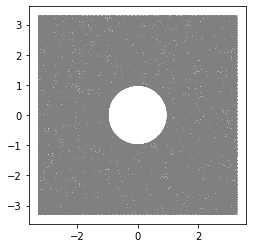

In [ ]:
# Computational domain
domain = Rectangle(Point(-Lx-th,-Ly-th),Point(Lx+th,Ly+th)) - Circle(Point(0, 0), Radius)

# Set PML subdomains (only for obtaining conformal meshes with the inner PML boundaries and identify the fluid domain)
domain.set_subdomain(1, domain)
domain.set_subdomain(2, Rectangle(Point(-Lx-th,-Ly-th),Point(-Lx,Ly+th)) + Rectangle(Point(Lx,-Ly-th),Point(Lx+th,Ly+th)))
domain.set_subdomain(3, Rectangle(Point(-Lx-th,-Ly-th),Point(Lx+th,-Ly)) + Rectangle(Point(-Lx-th,Ly),Point(Lx+th,Ly+th)))
domain.set_subdomain(4, Rectangle(Point(-Lx-th,-Ly-th),Point(-Lx,-Ly)) + Rectangle(Point(Lx,-Ly-th),Point(Lx+th,-Ly)) 
                         +Rectangle(Point(-Lx-th,Ly),Point(-Lx,Ly+th)) + Rectangle(Point(Lx,Ly),Point(Lx+th,Ly+th)))

# Create mesh
mesh = generate_mesh(domain, 60) # Values 30,60,120,240
print("Number of vertices: ",mesh.coordinates().shape[0])
print("Mesh h_min, h_max: ", mesh.hmin(), mesh.hmax())

# Plot mesh
plot(mesh)
plt.show()

#### Compute boundary and sudomain markers

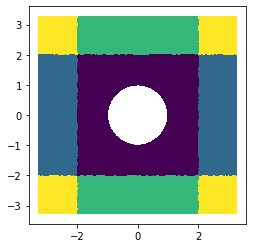

In [ ]:
# Initialize subdomain and boundary markers
tol = 1e-3
PML_boundary = CompiledSubDomain('on_boundary and (near(fabs(x[0]),Lx+th,tol) or near(fabs(x[1]),Ly+th,tol))', Lx=Lx, Ly=Ly, th=th, tol=tol)
circle_boundary = CompiledSubDomain('on_boundary and pow(x[0],2)+pow(x[1],2) < pow(R,2) + tol', R=Radius, tol=tol)

# Initialize mesh function for boundary
boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
boundary_markers.set_all(0)
circle_boundary.mark(boundary_markers, 1) 
PML_boundary.mark(boundary_markers, 2) 

# Initialize mesh function for the physical domain
domain_markers = MeshFunction('size_t', mesh, 2, mesh.domains())

# Plot subdomain markers
plot(domain_markers)
plt.show()

#### Define the functional spaces and the integral measures

In [ ]:
# Define new measures associated with each exterior boundaries
dx = Measure('dx', domain=mesh, subdomain_data=domain_markers)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

# Define function space (Lagrange 1st polynomials)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Q = FunctionSpace(mesh, P1)
V = FunctionSpace(mesh, P1 * P1)

# Define variational unknowns (potential, Lagrange multiplier and 6 RAOs)
(u_re, u_im) = TrialFunctions(V)
(v_re, v_im) = TestFunctions(V)

#### Define source terms and Dirichlet boundary data

In [ ]:
# Define source term for the real and the imaginary part and null boundary conditions
zero = Constant("0.0")
f_re = zero
f_im = zero

# Define boundary conditions in the whole boundary for the real and the imaginary part
# Use homogeneous boundary conditions on the exterior boundary of the PML
g_re = Expression('cos(n*atan2(x[1],x[0]))', n=degree, degree=5)
g_im = Expression('sin(n*atan2(x[1],x[0]))', n=degree, degree=5)
bcs = [DirichletBC(V.sub(0), g_re, boundary_markers, 1), DirichletBC(V.sub(1), g_im, boundary_markers, 1), 
       DirichletBC(V.sub(0), zero, boundary_markers, 2), DirichletBC(V.sub(1), zero, boundary_markers, 2)]

#### Define the fluid and the PML coefficients

In [ ]:
# Define the absorption PML profile
sigma0=2e3
sx = Expression('fabs(x[0]) > Lx ? s0*pow(fabs(x[0])-Lx,2)/w : 0.', Lx=Lx, w=omega, s0=sigma0, degree=2)
sy = Expression('fabs(x[1]) > Ly ? s0*pow(fabs(x[1])-Ly,2)/w : 0.', Ly=Ly, w=omega, s0=sigma0, degree=2)

# Define the PML coefficients
gammax_div_gammay_re = 1/(sy*sy + 1) + (sx*sy)/(sy*sy + 1)
gammax_div_gammay_im = sx/(sy*sy + 1) - sy/(sy*sy + 1)
gammay_div_gammax_re = 1/(sx*sx + 1) + (sx*sy)/(sx*sx + 1)
gammay_div_gammax_im = sy/(sx*sx + 1) - sx/(sx*sx + 1)
gammax_dot_gammay_re = 1 - sx*sy
gammax_dot_gammay_im = sx + sy

# Define PDE coefficients
c2 = Expression('pow(vel,2)', vel=vel, degree=0)
w2 = Expression('pow(omega,2)', omega=omega, degree=0)
 
# Define PML matrices 
C_re = as_matrix(((gammay_div_gammax_re, zero), (zero, gammax_div_gammay_re)))
C_im = as_matrix(((gammay_div_gammax_im, zero), (zero, gammax_div_gammay_im)))
M_re = gammax_dot_gammay_re
M_im = gammax_dot_gammay_im

#### Define the variational problem and compute the FEM solution

In [ ]:
# Define variational formulation in the PML and fluid subdomains
a = c2*inner((C_re*grad(u_re)-C_im*grad(u_im)), grad(v_re))*dx + c2*inner((C_im*grad(u_re)+C_re*grad(u_im)), grad(v_im))*dx \
    -w2*(M_re*u_re-M_im*u_im)*v_re*dx - w2*(M_im*u_re+M_re*u_im)*v_im*dx
L = f_re*v_re*dx + f_im*v_im*dx

# Assembly matrix and source vector
A=assemble(a)
b=assemble(L)

# Apply boundary conditions to matrix and source vector
for bc in bcs:
    bc.apply(A)
    bc.apply(b)

# Compute solution and get real and imaginary parts
w = Function(V)
solve(A, w.vector(), b)
(u_re, u_im) = w.split(True)
u_re.rename("Re(u)", "Real FE approx.")
u_im.rename("Im(u)", "Imag. FE approx.")

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Calling FFC just-in-time (JIT) compiler, this may take some time.


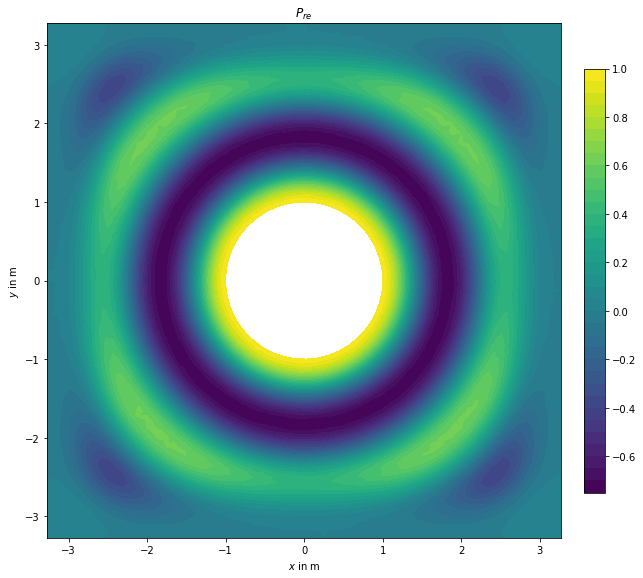

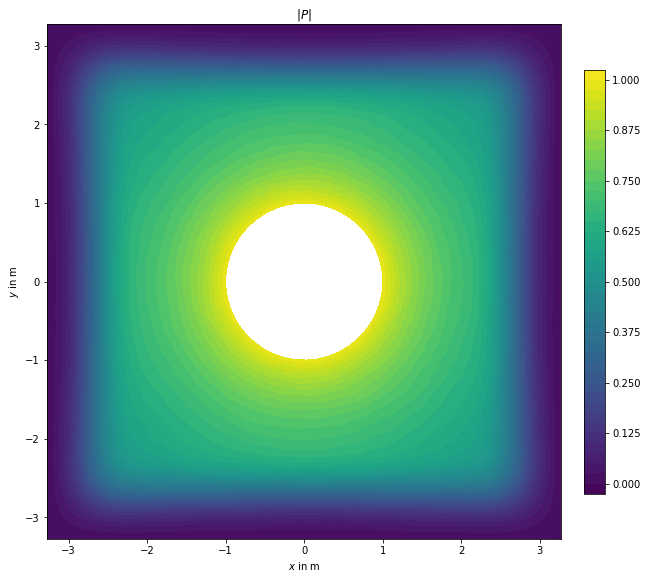

In [ ]:
def plot_soundfield(u):
    '''plots solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = dolfin.plot(u)
    plt.xlabel(r'$x$ in m')
    plt.ylabel(r'$y$ in m')
    plt.colorbar(fig, fraction=0.038, pad=0.04);

# plot sound field
plot_soundfield(u_re)
plt.title(r'$P_{re}$')
plot_soundfield(sqrt(u_re**2+u_im**2))
plt.title(r'$|P|$');

#### Define the exact solution and compute the $L^2$- relative error in the fluid subdomain

In this case, since the Dirichlet data is an harmonic expression (this is, a complex-exponential $e^{in\theta}$) on the interior circle, the solution is given by
$$
P(r,\theta)=e^{in\theta}H^{(1)}_{n}(kr)
$$
with $k=\omega/c$, $r=\sqrt{x^2+y^2}$, and $\theta=\mathrm{arctan}(y/x)$.

In [ ]:
# Define the exact solution based on the Hankel function of first kind and order "degree"
# Real part of the exact solution
class Exact_re(UserExpression):
    def __init__(self, Radius, A, k, n, **kwargs):
        self.Radius = Radius
        self.A = A
        self.k = k
        self.n = n
        super().__init__(**kwargs)

    def eval(self, value, x):
        r=np.sqrt(x[0]**2+x[1]**2)
        theta=np.arctan2(x[1],x[0])
        val = spe.hankel1(self.n, self.k*self.Radius)
        value[0] = np.real(np.exp(1j*self.n*theta)*spe.hankel1(self.n, self.k*r)/val)

    def value_shape(self):
        return ()

class Exact_im(UserExpression):
    def __init__(self, Radius, A, k, n, **kwargs):
        self.Radius = Radius
        self.A = A
        self.k = k
        self.n = n
        super().__init__(**kwargs)

    def eval(self, value, x):
        r=np.sqrt(x[0]**2+x[1]**2)
        theta=np.arctan2(x[1],x[0])
        val = spe.hankel1(self.n, self.k*self.Radius)
        value[0] = np.imag(np.exp(1j*self.n*theta)*spe.hankel1(self.n, self.k*r)/val)

    def value_shape(self):
        return ()

# Expressions of the exact solution and interpolation
uex_re = Exact_re(Radius=Radius, A=amplitude, k=omega/vel, n=degree, degree=3)
uex_im = Exact_im(Radius=Radius, A=amplitude, k=omega/vel, n=degree, degree=3)
uex_re_interp = interpolate(uex_re, Q)
uex_im_interp = interpolate(uex_im, Q) 
uex_re_interp.rename("Re(u_ex)", "Real exact")
uex_im_interp.rename("Im(u_ex)", "Imag. exact")

# Compute relative error in L2-norm of the complex-value functions only in the fluid domain
err_re = Function(Q)
err_im = Function(Q)
err_re.vector().set_local(uex_re_interp.vector().get_local()-u_re.vector().get_local())
err_im.vector().set_local(uex_im_interp.vector().get_local()-u_im.vector().get_local())
error_rel=np.sqrt(assemble(err_re**2*dx(1))+assemble(err_im**2*dx(1)))/np.sqrt(assemble(uex_re_interp**2*dx(1))+assemble(uex_im_interp**2*dx(1)))
print("L2-relative error (%): ", error_rel*100.)


Calling FFC just-in-time (JIT) compiler, this may take some time.
L2-relative error (%):  1.1775777225236


**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).